# Preparation

In [1]:
# Ensure that we are using GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ff0bc5d0-32d7-919f-15cc-5e03f9dd59a8)


In [2]:
# Importing helpers functions
import os 

if not os.path.exists("helpers.py"):
    !wget https://raw.githubusercontent.com/theveloper-pl/Domainnet-Vision/main/helpers.py
else:
    print("[INFO] 'helper.py' already exists, skipping download.")

from helpers import *

[INFO] 'helper.py' already exists, skipping download.


In [3]:
import tensorflow_datasets as tfds

In [4]:
# Check if dataset exists in tensorflow datasets library
datasets_list = tfds.list_builders()

target_dataset = "domainnet"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'domainnet' in TensorFlow Datasets: True


In [5]:
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name="domainnet",
                                             split=["train", "test"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120906 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/domainnet/real/1.0.0.incompleteFWVVEE/domainnet-train.tfrecord*...:   0%| …

Generating test examples...:   0%|          | 0/52041 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/domainnet/real/1.0.0.incompleteFWVVEE/domainnet-test.tfrecord*...:   0%|  …

Dataset domainnet downloaded and prepared to /root/tensorflow_datasets/domainnet/real/1.0.0. Subsequent calls will reuse this data.


In [6]:
# Check basic info of dataset

print("Features: ")
print(ds_info.features)

class_names = ds_info.features["label"].names
print("Class names: ")
print(class_names[:10])

train_one_sample = train_data.take(1)
print("Data sample")
print(train_one_sample)

# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Domainnet (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)

Features: 
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=345),
})
Class names: 
['aircraft_carrier', 'airplane', 'alarm_clock', 'ambulance', 'angel', 'animal_migration', 'ant', 'anvil', 'apple', 'arm']
Data sample
<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

  Image shape: (640, 640, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Domainnet (tensor form): 41
  Class name (str form): bread
        


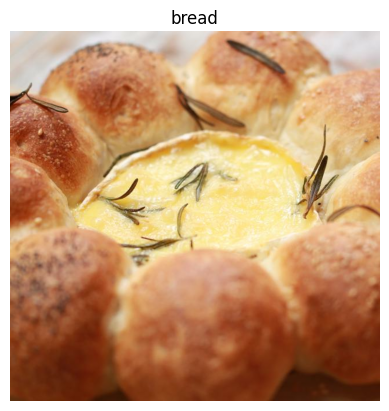

In [7]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) #
plt.axis(False);

In [8]:
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape])  # resize the image
    image = tf.cast(image, tf.float32)  # change the datatype to float32

    # If the label has more than 1 dimension, reduce it to 1 dimension
    if len(label.shape) > 1:
        label = tf.squeeze(label)

    return image, label


In [9]:
# Preprocess a single sample image and check the outputs
preprocessed_img, label = preprocess_img(image, label)
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[218 221 226]
  [218 221 226]
  [218 221 226]
  ...
  [223 219 220]
  [223 219 220]
  [223 219 220]]

 [[217 220 225]
  [217 220 225]
  [217 220 225]
  ...
  [223 219 220]
  [224 220 221]
  [224 220 221]]]...,
Shape: (640, 640, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[217.07143 220.07143 225.07143]
  [218.64285 220.07143 224.2857 ]
  [219.07143 220.07143 224.07143]
  ...
  [221.95409 217.95409 218.95409]
  [222.94388 218.94388 219.94388]
  [223.92857 219.92857 220.92857]]

 [[219.      218.42857 223.2296 ]
  [219.      219.21428 221.64285]
  [220.      218.42857 220.20407]
  ...
  [223.78572 219.78572 220.78572]
  [224.78572 220.78572 221.78572]
  [225.78572 221.78572 222.78572]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


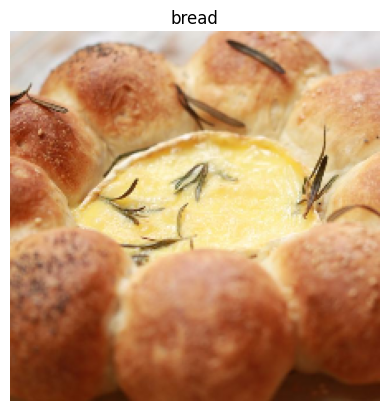

In [10]:
# Show preprocessed image
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [11]:

# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)


train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [12]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")


# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)


# Using callbacks I've experienced some code crash so at the end I've decided to use only lr reduction callback and early stopping callback

In [13]:
# Turn on mixed precision training - Training model will go faster
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

In [14]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")


# Testing EfficientNetB0

In [15]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Unfreeze top 10 layers
base_model.trainable = True 
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations

# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)


model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])






16705208/16705208 [==============================] - 2s 0us/step


In [16]:
# Model info

for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

print(model.summary())

input_layer True float32 <Policy "float32">
data_augmentation True float32 <Policy "mixed_float16">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                

In [17]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Start to fine-tune (all layers)
history_domainnet = model.fit(train_data,
                              epochs=100, # fine-tune for a maximum of 100 epochs - early_stopping will work
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              callbacks = [early_stopping, reduce_lr],
                              validation_steps=int(0.15 * len(test_data)), 
                              ) 

Epoch 1/100
3779/3779 [==============================] - 683s 176ms/step - loss: 1.9820 - accuracy: 0.5515 - val_loss: 1.1341 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 2/100
3779/3779 [==============================] - 330s 87ms/step - loss: 1.2831 - accuracy: 0.6784 - val_loss: 1.0074 - val_accuracy: 0.7428 - lr: 1.0000e-04
Epoch 3/100
3779/3779 [==============================] - 247s 65ms/step - loss: 1.1299 - accuracy: 0.7111 - val_loss: 0.9746 - val_accuracy: 0.7517 - lr: 1.0000e-04
Epoch 4/100
3779/3779 [==============================] - 218s 57ms/step - loss: 1.0314 - accuracy: 0.7337 - val_loss: 0.9342 - val_accuracy: 0.7610 - lr: 1.0000e-04
Epoch 5/100
3779/3779 [==============================] - 199s 52ms/step - loss: 0.9539 - accuracy: 0.7511 - val_loss: 0.9153 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 6/100
3779/3779 [==============================] - 189s 50ms/step - loss: 0.8945 - accuracy: 0.7635 - val_loss: 0.9044 - val_accuracy: 0.7649 - lr: 1.0000e-04
Epoch 7/1

In [18]:
# Evaluate model (unsaved version) on whole test dataset
results_domainnet = model.evaluate(test_data)
results_domainnet

1627/1627 [==============================] - 56s 34ms/step - loss: 0.8756 - accuracy: 0.7855


[0.8755835294723511, 0.7854576110839844]

In [19]:
# Unfreezing more layers

from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Unfreeze top 10 layers
base_model.trainable = True 
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations

# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)


model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])






In [20]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Start to fine-tune (all layers)
history_domainnet = model.fit(train_data,
                              epochs=100, # fine-tune for a maximum of 100 epochs - early_stopping will work
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              callbacks = [early_stopping, reduce_lr],
                              validation_steps=int(0.15 * len(test_data)), 
                              ) 

Epoch 1/100
3779/3779 [==============================] - 202s 50ms/step - loss: 1.8553 - accuracy: 0.5748 - val_loss: 1.0759 - val_accuracy: 0.7301 - lr: 1.0000e-04
Epoch 2/100
3779/3779 [==============================] - 188s 50ms/step - loss: 1.1625 - accuracy: 0.7047 - val_loss: 0.9499 - val_accuracy: 0.7565 - lr: 1.0000e-04
Epoch 3/100
3779/3779 [==============================] - 185s 49ms/step - loss: 0.9852 - accuracy: 0.7439 - val_loss: 0.9025 - val_accuracy: 0.7704 - lr: 1.0000e-04
Epoch 4/100
3779/3779 [==============================] - 186s 49ms/step - loss: 0.8638 - accuracy: 0.7699 - val_loss: 0.8944 - val_accuracy: 0.7692 - lr: 1.0000e-04
Epoch 5/100
3779/3779 [==============================] - 187s 49ms/step - loss: 0.7712 - accuracy: 0.7918 - val_loss: 0.9058 - val_accuracy: 0.7723 - lr: 1.0000e-04
Epoch 6/100
3779/3779 [==============================] - 187s 49ms/step - loss: 0.6857 - accuracy: 0.8105 - val_loss: 0.8924 - val_accuracy: 0.7773 - lr: 1.0000e-04
Epoch 7/10

In [21]:
# Evaluate model (unsaved version) on whole test dataset
results_domainnet = model.evaluate(test_data)
results_domainnet

1627/1627 [==============================] - 54s 33ms/step - loss: 0.9094 - accuracy: 0.7892


[0.9093506336212158, 0.7892046570777893]

In [22]:
# Adding more layers

In [23]:
# Unfreezing more layers

from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Unfreeze top 10 layers
base_model.trainable = True 
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)

x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations

# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)


model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])






In [24]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Start to fine-tune (all layers)
history_domainnet = model.fit(train_data,
                              epochs=100, # fine-tune for a maximum of 100 epochs - early_stopping will work
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              callbacks = [early_stopping, reduce_lr],
                              validation_steps=int(0.15 * len(test_data)), 
                              ) 

Epoch 1/100
3779/3779 [==============================] - 201s 50ms/step - loss: 3.1852 - accuracy: 0.3655 - val_loss: 1.2834 - val_accuracy: 0.6961 - lr: 1.0000e-04
Epoch 2/100
3779/3779 [==============================] - 189s 50ms/step - loss: 1.8211 - accuracy: 0.5788 - val_loss: 1.0769 - val_accuracy: 0.7414 - lr: 1.0000e-04
Epoch 3/100
3779/3779 [==============================] - 189s 50ms/step - loss: 1.5544 - accuracy: 0.6311 - val_loss: 0.9976 - val_accuracy: 0.7560 - lr: 1.0000e-04
Epoch 4/100
3779/3779 [==============================] - 189s 50ms/step - loss: 1.3878 - accuracy: 0.6665 - val_loss: 0.9559 - val_accuracy: 0.7619 - lr: 1.0000e-04
Epoch 5/100
3779/3779 [==============================] - 189s 50ms/step - loss: 1.2760 - accuracy: 0.6910 - val_loss: 0.9276 - val_accuracy: 0.7723 - lr: 1.0000e-04
Epoch 6/100
3779/3779 [==============================] - 190s 50ms/step - loss: 1.1851 - accuracy: 0.7081 - val_loss: 0.9152 - val_accuracy: 0.7739 - lr: 1.0000e-04
Epoch 7/10

In [25]:
# Evaluate model (unsaved version) on whole test dataset
results_domainnet = model.evaluate(test_data)
results_domainnet

1627/1627 [==============================] - 55s 34ms/step - loss: 0.8528 - accuracy: 0.7992


[0.8527747392654419, 0.7992160320281982]

In [30]:
# Trying newest model EfficientNetB7

from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB7(include_top=False)


# Unfreeze top 10 layers
base_model.trainable = True 
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)

x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations

# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)


model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])






258076736/258076736 [==============================] - 12s 0us/step


In [31]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Start to fine-tune (all layers)
history_domainnet = model.fit(train_data,
                              epochs=100, # fine-tune for a maximum of 100 epochs - early_stopping will work
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              callbacks = [early_stopping, reduce_lr],
                              validation_steps=int(0.15 * len(test_data)), 
                              ) 

Epoch 1/100
3779/3779 [==============================] - 1424s 369ms/step - loss: 2.9774 - accuracy: 0.4265 - val_loss: 1.2356 - val_accuracy: 0.7126 - lr: 1.0000e-04
Epoch 2/100
3779/3779 [==============================] - 968s 256ms/step - loss: 1.8210 - accuracy: 0.5955 - val_loss: 1.0607 - val_accuracy: 0.7471 - lr: 1.0000e-04
Epoch 3/100
3779/3779 [==============================] - 868s 230ms/step - loss: 1.5404 - accuracy: 0.6462 - val_loss: 0.9851 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 4/100
3779/3779 [==============================] - 833s 220ms/step - loss: 1.3588 - accuracy: 0.6822 - val_loss: 0.9396 - val_accuracy: 0.7756 - lr: 1.0000e-04
Epoch 5/100
3779/3779 [==============================] - 812s 215ms/step - loss: 1.2270 - accuracy: 0.7083 - val_loss: 0.9206 - val_accuracy: 0.7809 - lr: 1.0000e-04
Epoch 6/100
3779/3779 [==============================] - 790s 209ms/step - loss: 1.1166 - accuracy: 0.7308 - val_loss: 0.9120 - val_accuracy: 0.7825 - lr: 1.0000e-04
Epo

In [32]:
# Evaluate model (unsaved version) on whole test dataset
results_domainnet = model.evaluate(test_data)
results_domainnet

1627/1627 [==============================] - 293s 180ms/step - loss: 0.9059 - accuracy: 0.8040


[0.9059021472930908, 0.8040006756782532]

In [33]:
# Adding more layers EfficientNetB7

from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB7(include_top=False)


# Unfreeze top 10 layers
base_model.trainable = True 
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)

x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x) # added layer
x = layers.BatchNormalization()(x) # added layer
x = layers.Dropout(0.3)(x) # added layer

x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations

# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)


model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])


In [34]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Start to fine-tune (all layers)
history_domainnet = model.fit(train_data,
                              epochs=100, # fine-tune for a maximum of 100 epochs - early_stopping will work
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              callbacks = [early_stopping, reduce_lr],
                              validation_steps=int(0.15 * len(test_data)), 
                              ) 

Epoch 1/100
3779/3779 [==============================] - 808s 206ms/step - loss: 3.7221 - accuracy: 0.3220 - val_loss: 1.5584 - val_accuracy: 0.6694 - lr: 1.0000e-04
Epoch 2/100
3779/3779 [==============================] - 777s 205ms/step - loss: 2.1101 - accuracy: 0.5525 - val_loss: 1.2043 - val_accuracy: 0.7213 - lr: 1.0000e-04
Epoch 3/100
3779/3779 [==============================] - 778s 206ms/step - loss: 1.7154 - accuracy: 0.6223 - val_loss: 1.0673 - val_accuracy: 0.7490 - lr: 1.0000e-04
Epoch 4/100
3779/3779 [==============================] - 775s 205ms/step - loss: 1.5134 - accuracy: 0.6596 - val_loss: 1.0317 - val_accuracy: 0.7555 - lr: 1.0000e-04
Epoch 5/100
3779/3779 [==============================] - 773s 204ms/step - loss: 1.3698 - accuracy: 0.6877 - val_loss: 0.9684 - val_accuracy: 0.7710 - lr: 1.0000e-04
Epoch 6/100
3779/3779 [==============================] - 774s 205ms/step - loss: 1.2509 - accuracy: 0.7111 - val_loss: 0.9594 - val_accuracy: 0.7752 - lr: 1.0000e-04
Epoc

# Trying different model

In [27]:
# Unfreezing more layers

from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNetRS50(include_top=False)
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Unfreeze top 10 layers
base_model.trainable = True 
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = layers.Rescaling(1./255)(x)
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)

x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations

# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)


model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])






In [28]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Start to fine-tune (all layers)
history_resnet = model.fit(train_data,
                              epochs=100, # fine-tune for a maximum of 100 epochs - early_stopping will work
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              callbacks = [early_stopping, reduce_lr],
                              validation_steps=int(0.15 * len(test_data)), 
                              ) 

Epoch 1/100
3779/3779 [==============================] - 930s 243ms/step - loss: 2.8108 - accuracy: 0.4413 - val_loss: 1.2323 - val_accuracy: 0.7145 - lr: 1.0000e-04
Epoch 2/100
3779/3779 [==============================] - 377s 99ms/step - loss: 1.6174 - accuracy: 0.6367 - val_loss: 1.0272 - val_accuracy: 0.7567 - lr: 1.0000e-04
Epoch 3/100
3779/3779 [==============================] - 304s 80ms/step - loss: 1.3536 - accuracy: 0.6885 - val_loss: 0.9655 - val_accuracy: 0.7719 - lr: 1.0000e-04
Epoch 4/100
3779/3779 [==============================] - 293s 77ms/step - loss: 1.1847 - accuracy: 0.7217 - val_loss: 0.9383 - val_accuracy: 0.7773 - lr: 1.0000e-04
Epoch 5/100
3779/3779 [==============================] - 292s 77ms/step - loss: 1.0613 - accuracy: 0.7463 - val_loss: 0.9092 - val_accuracy: 0.7893 - lr: 1.0000e-04
Epoch 6/100
3779/3779 [==============================] - 293s 77ms/step - loss: 0.9629 - accuracy: 0.7681 - val_loss: 0.8839 - val_accuracy: 0.7924 - lr: 1.0000e-04
Epoch 7/1

In [29]:
# Evaluate model (unsaved version) on whole test dataset
results_resnet = model.evaluate(test_data)
results_resnet

1627/1627 [==============================] - 87s 54ms/step - loss: 0.8443 - accuracy: 0.8170


[0.844318687915802, 0.8169519901275635]